In [1]:
# Mounting your Google Drive is optional, and you could also simply copy and
# upload the data to your colab instance. This manula upload is also easy to do,
# but you will have to figure out how to do it.
COLAB = True
if COLAB:
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
if COLAB:
    work_dir = "/content/drive/MyDrive/CS444/549_mp5/"
else:
    work_dir = "/home/changl25/private/assignment4/"
if not os.path.exists(work_dir) and COLAB:
  !ln -s "/content/drive/MyDrive/CS444/assignment4/" $work_dir # TODO: Fill your Assignment 3 path
os.chdir(work_dir)
!pwd

/content/drive/MyDrive/CS444/549_mp5


In [3]:
# download dataset

# %pip install -U gdown
# import gdown
# url = "https://drive.google.com/uc?id=16DaymD8ZKPWmCVwCRmPL1i5_ugR6ieVx"
# gdown.download(url, quiet=False)
# !unzip -qqo data.zip
# !rm data.zip

In [4]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize
from torchvision import transforms

In [5]:
# global variable
device = torch.device("cuda:0")

In [ ]:
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return img, mask
        return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
    
class RandomResizedCrop:
    def __init__(self, size, scale=(0.08, 1.0), ratio=(0.75, 1.3)):
        self.size = size
        self.scale = scale
        self.ratio = ratio
    def __call__(self, img, mask):
        i, j, h, w = transforms.RandomResizedCrop.get_params(img, scale=self.scale, ratio=self.ratio)
        croped_img = transforms.functional.cropped(img, i, j, h, w)
        croped_mask = transforms.functional.cropped(mask, i, j, h, w)
        
        img = transforms.functional.resize(croped_img, self.size, Image.BILINEAR)
        mask = transforms.functional.resize(croped_mask, self.size, Image.NEAREST)
        return img, mask
    
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, img, mask):
        for transform in self.transforms:
            img, mask = transform(img, mask)
        return img, mask

In [6]:
class SegmentationDataset(data.Dataset):
    """
    Data loader for the Segmentation Dataset. If data loading is a bottleneck,
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as
    to limit delays due to disk reads.
    """

    def __init__(self, split="train", data_dir="data", transform=None):
        assert (split in ["train", "val", "test"])
        self.img_dir = os.path.join(data_dir, split)
        self.classes = []
        with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
            for l in f:
                self.classes.append(l.rstrip())
        self.n_classes = len(self.classes)
        self.split = split
        self.data = glob.glob(self.img_dir + '/*.jpg')
        self.data = sorted([os.path.splitext(l)[0] for l in self.data])
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = Image.open(self.data[index] + '.jpg')
        if self.split == 'test':
            gt = Image.new('RGB', img.size)
        else:
            gt = Image.open(self.data[index] + '.png')
        img = ToTensor()(img)
        gt = ToTensor()(gt)
        if self.transform is not None:
            img, gt = self.transform(img, gt)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        gt = gt.long().unsqueeze(0)
        # gt = np.asarray(gt)
        # gt = torch.from_numpy(np.array(gt)).long().unsqueeze(0)
        return img, gt

In [7]:
train_dataset = SegmentationDataset(split='train')

In [ ]:
transforms = Compose([
    RandomResizedCrop(224, scale=(0.5, 1.0))
    RandomHorizontalFlip(),
]
)
train_dataset = SegmentationDataset(split='train', transform=transforms)

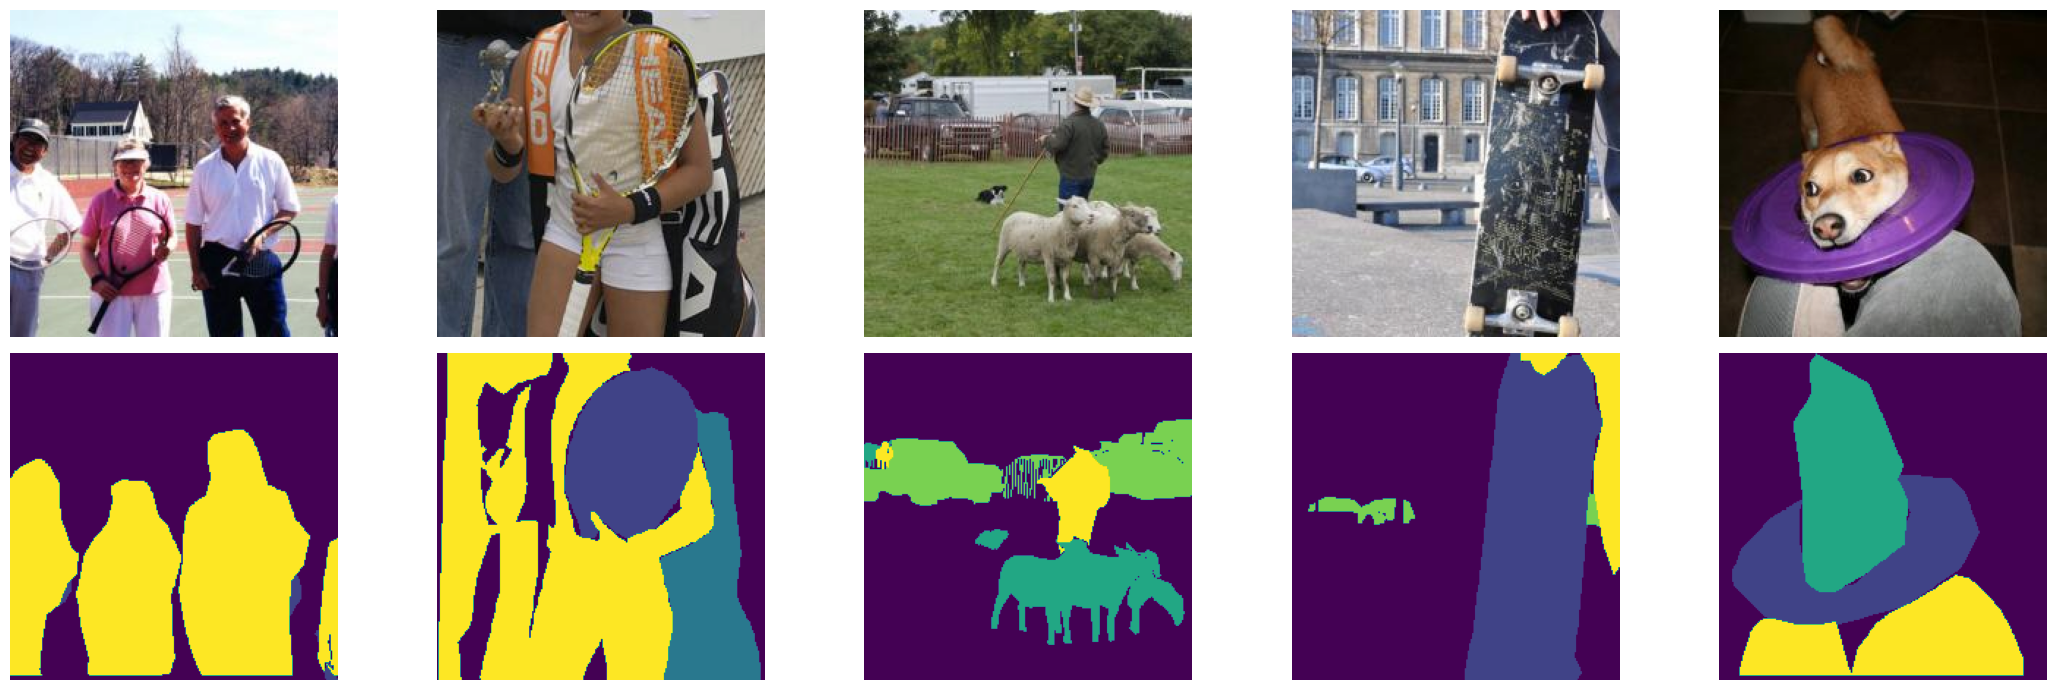

In [8]:
# vis the training set
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    img, gt = train_dataset[idx]
    img = std * img.permute((1, 2, 0)).cpu().numpy() + mean
    gt = gt.squeeze().numpy()
    ax.imshow((img * 255).astype(np.uint8))
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(gt)
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_trainset.png')

In [9]:
train_dataloader = data.DataLoader(train_dataset, batch_size=32,
                                    shuffle=True, num_workers=2,
                                    drop_last=True)

val_dataset = SegmentationDataset(split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=1,
                                 shuffle=False, num_workers=0,
                                 drop_last=False)

In [10]:
##########
#TODO: design your own network here. The expectation is to write from scratch. But it's okay to get some inspiration
#from conference paper. We are providing a very simple network that does a single 1x1 convolution to prdict the class label.
##########

# conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4
class ResNetEncoder(nn.Module):
    def __init__(self, pretrained_resnet):
        self.inplanes = 64
        super(ResNetEncoder, self).__init__()
        self.conv1 = pretrained_resnet.conv1
        self.bn1 = pretrained_resnet.bn1
        self.relu = pretrained_resnet.relu
        self.maxpool = pretrained_resnet.maxpool
        self.layer1 = pretrained_resnet.layer1
        self.layer2 = pretrained_resnet.layer2
        self.layer3 = pretrained_resnet.layer3
        self.layer4 = pretrained_resnet.layer4

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print(x.shape)
        f1 = self.layer1(x)
        # print(f1.shape)
        f2 = self.layer2(f1)
        # print(f2.shape)
        f3 = self.layer3(f2)
        # print(f3.shape)
        f4 = self.layer4(f3)
        # print(f4.shape)
        return f1, f2, f3, f4



In [20]:
class SimpleSegNet(nn.Module):
    def __init__(self, n_class, encoder):
        super(SimpleSegNet, self).__init__()
        self.encoder = encoder
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.classifier = nn.Conv2d(64, out_channels= n_class, kernel_size=1)

    def forward(self, x): # modify forward path
        _, _, _, f4 = self.encoder(x)
        f3 = self.conv1(f4)
        f3 = nn.functional.interpolate(f3, (f3.shape[2] * 2, f3.shape[3] * 2), mode="bilinear", align_corners=True)
        f2 = self.conv2(f3)
        f2 = nn.functional.interpolate(f2, (f2.shape[2] * 2, f2.shape[3] * 2), mode="bilinear", align_corners=True)
        f1 = self.conv3(f2)
        f1 = nn.functional.interpolate(f1, (f1.shape[2] * 2, f1.shape[3] * 2), mode="bilinear", align_corners=True)
        out = self.classifier(f1)
        out = nn.functional.interpolate(out, size=x.size()[2:], mode='bilinear', align_corners=True)
        return out

In [12]:
class UNetDecoder(nn.Module):
    def __init__(self, n_class):
        super(UNetDecoder, self).__init__()
        self.upsampler1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.upsampler2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsampler3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upsampler4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.upsampler5 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.classifier = nn.Conv2d(64, n_class, kernel_size=1)
    def forward(self, f1, f2, f3, f4):
        # print(f4.shape)
        x = self.upsampler1(f4)
        x = self.relu(x)
        x = torch.cat([x, f3], dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        # print(x.shape)
        x = self.upsampler2(x)
        x = self.relu(x)
        x = torch.cat([x, f2], dim=1)
        x = self.conv2(x)
        x = self.relu(x)
        # print(x.shape)

        x = self.upsampler3(x)
        x = self.relu(x)
        x = torch.cat([x, f1], dim=1)
        x = self.conv3(x)
        x = self.relu(x)
        # print(x.shape)

        x = self.upsampler4(x)
        x = self.relu(x)
        # x = torch.cat([x, f1], dim=1)
        # x = self.conv4(x)
        x = self.upsampler5(x)
        x = self.relu(x)
        # print(x.shape)

        x = self.classifier(x)
        # print(x.shape)

        return x
    
class UNetSingleDecoder(nn.Module):
    def __init__(self, n_class, pre_processed=False):
        super(UNetSingleDecoder, self).__init__()
        # self.upsampler1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1)

        self.upsampler3 = nn.ConvTranspose2d(128 + 64, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1)

        self.upsampler4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.upsampler5 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.classifier = nn.Conv2d(64, n_class, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        if pre_processed:
            self.pre_processed = True 
            self.f3_1x1_conv = nn.Conv2d(256, 256, kernel_size=1)
            self.f2_1x1_conv = nn.Conv2d(128, 128, kernel_size=1)
            self.f1_1x1_conv = nn.Conv2d(64, 64, kernel_size=1)
    def forward(self, f1, f2, f3, f4):
        # print(f4.shape)
        if pre_processed:
            f3 = self.f3_1x1_conv(f3)
            f2 = self.f2_1x1_conv(f2)
            f1 = self.f1_1x1_conv(f1)
        x = self.upsample(f4)
        x = torch.cat([x, f3], dim=1)
        x = self.conv1(x)
        # x = self.relu(x)
        # print(x.shape)
        x = self.upsample(x)
        # x = self.relu(x)
        x = torch.cat([x, f2], dim=1)
        x = self.conv2(x)
        # x = self.relu(x)
        # print(x.shape)
        x = self.upsample(x)
        # x = self.relu(x)
        x = torch.cat([x, f1], dim=1)
        x = self.conv3(x)
        # x = self.relu(x)
        # print(x.shape)
        x = self.classifier(x)

        x = self.upsample(x)
        x = self.upsample(x)
        # print(x.shape)

        # print(x.shape)

        return x

class ResNet_UNet(nn.Module):
    def __init__(self, encoder, decoder, bottleneck):
        super(ResNet_UNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bottleneck = bottleneck
    def forward(self, x):
        f1, f2, f3, f4 = self.encoder(x)
        out = self.decoder(f1, f2, f3, f4)
        return out

In [13]:
##########
#TODO: define your loss function here, we provide the basic Cross Entropy Loss
##########
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        self.criterion = nn.CrossEntropyLoss(reduction='mean')

    def forward(self, prediction, target):
        return self.criterion(prediction, target.squeeze(1))

In [14]:
########################################################################
# No need to modify below
# Evaluate sementic segmentation
# 1. Average precision of all classes and the average
# 2. Mean IOU of all classes and the average


import numpy as np
from sklearn.metrics import confusion_matrix


def segmentation_eval(gts, preds, classes):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    for i in range(len(classes)):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious


def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
        ap, prec, rec = calc_pr(gts == i, preds[:, i:i + 1, :, :])
        aps.append(ap)
    return aps


def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1, 1))
    out = out.astype(np.float64).reshape((-1, 1))

    tog = np.concatenate([gt, out], axis=1) * 1.
    ind = np.argsort(tog[:, 1], axis=0)[::-1]
    tog = tog[ind, :]
    cumsumsortgt = np.cumsum(tog[:, 0])
    cumsumsortwt = np.cumsum(tog[:, 0] - tog[:, 0] + 1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:, 0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec


def voc_ap(rec, prec):
    rec = rec.reshape((-1, 1))
    prec = prec.reshape((-1, 1))
    z = np.zeros((1, 1))
    o = np.ones((1, 1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0] + 1
    ap = np.sum((mrec[I] - mrec[I - 1]) * mpre[I])
    return ap


def compute_confusion_matrix(gts, preds):
    preds_cls = np.argmax(preds, 1)
    gts = gts[:, 0, :, :]
    conf = confusion_matrix(gts.ravel(), preds_cls.ravel())
    inter = np.diag(conf)
    union = np.sum(conf, 0) + np.sum(conf, 1) - np.diag(conf)
    union = np.maximum(union, 1)
    return inter / union, conf


def val(model, val_dataloader, device):
    preds, gts = [], []

    # Put model in evaluation mode.
    model.eval()
    for i, batch in enumerate(val_dataloader):
        img, gt = batch
        img = img.to(device)
        gt = gt.to(device).long()
        pred = model(img)
        pred = torch.softmax(pred, 1)
        preds.append(pred.detach().cpu().numpy())
        gts.append(gt.detach().cpu().numpy())
    gts = np.concatenate(gts, 0)
    preds = np.concatenate(preds, 0)
    aps, ious = segmentation_eval(gts, preds, val_dataset.classes)

    return preds, aps, ious

In [15]:

# TODO: implement your train loop here, we provide a very basic training loop
def train(model, criterion, optimizer, train_dataloader, device):
    model.train()
    for i, batch in enumerate(train_dataloader):
        # Zero out gradient blobs in the optimizer
        optimizer.zero_grad()
        img, gt = batch

        # Move data to device for training
        img = img.to(device)
        gt = gt.to(device).long()

        # Get model predictions
        pred = model(img)
        loss = criterion(pred, gt)
        loss.backward()

        # Take a step to update network parameters.
        optimizer.step()

def train_val(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, decay_epochs, device):
    aps_lst = []
    ious_lst = []
    preds_lst = []
    best_aps = 0
    unchange_epochs = 0
    for epoch in tqdm(range(num_epochs)):
        if unchange_epochs > decay_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5
            unchange_epochs = 0
        train(model, criterion, optimizer, train_dataloader, device)
        # consider reducing learning rate
        # test results on validation set
        # if epoch % 3 ==0 or epoch == num_epochs-1:
        print("epoch: {}, lr: {}, performance on validation set".format(epoch, optimizer.param_groups[0]['lr']))
        preds, aps, ious = val(model, val_dataloader, device)
        aps_lst.append(np.mean(aps))
        ious_lst.append(np.mean(ious))
        preds_lst.append(preds)
        if best_aps < np.mean(aps) * (1.01):
          best_aps = np.mean(aps)
          unchange_epochs = 0
        else:
          unchange_epochs += 1
    return aps_lst, ious_lst, preds_lst

In [16]:
def predict(model, test_dataloader, device):
    preds = []
    # Put model in evaluation mode.
    model.eval()
    for i, batch in enumerate(test_dataloader):
        img, _ = batch
        img = img.to(device)
        pred = model(img)
        pred = torch.softmax(pred, 1)
        preds.append(pred.detach().cpu().numpy())
    preds = np.concatenate(preds, 0)
    # Put model back in training mode
    return preds

def vis_pred(mean, std, preds, test_dataset, save_path):
    fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
    for idx, ax_i in enumerate(axs.T):
        ax = ax_i[0]
        img, _ = test_dataset[idx]
        img = std * img.permute((1, 2, 0)).cpu().numpy() + mean
        ax.imshow((img * 255).astype(np.uint8))
        ax.axis('off')
        ax = ax_i[1]
        pred = np.argmax(preds[idx], 0)
        ax.imshow(pred)
        ax.axis('off')
    fig.tight_layout()
    plt.savefig(save_path)

In [15]:
encoder = ResNetEncoder(models.resnet18(weights=models.ResNet18_Weights.DEFAULT))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In [19]:
decoder = UNetDecoder(n_class=len(train_dataset.classes)).to(device)
model = ResNet_UNet(encoder=encoder, decoder=decoder, bottleneck=None).to(device)

In [20]:
pred = model(next(iter(train_dataloader))[0].to(device))
target = next(iter(train_dataloader))[1].to(device)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [21]:

# TODO: Implement your training cycles, make sure you evaluate on validation
# dataset and compute evaluation metrics every so often.
# You may also want to save models that perform well.
# Tune your own optimizer and number of epochs, learning rate, etc

criterion = Criterion().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 200
decay_epochs = 30

In [22]:
criterion(pred, target.squeeze(-1))

tensor(1.7304, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [23]:
aps_lst, ious_lst, preds_lst = train_val(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, decay_epochs, device)

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, lr: 0.0001, performance on validation set
          background: AP: 0.73, IoU: 0.57
              sports: AP: 0.03, IoU: 0.00
           accessory: AP: 0.05, IoU: 0.00
              animal: AP: 0.08, IoU: 0.00
             vehicle: AP: 0.12, IoU: 0.00
              person: AP: 0.17, IoU: 0.03
                mean: AP: 0.20, IoU: 0.10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 1, lr: 0.0001, performance on validation set
          background: AP: 0.89, IoU: 0.58
              sports: AP: 0.05, IoU: 0.00
           accessory: AP: 0.07, IoU: 0.00
              animal: AP: 0.16, IoU: 0.00
             vehicle: AP: 0.19, IoU: 0.00
              person: AP: 0.27, IoU: 0.00
                mean: AP: 0.27, IoU: 0.10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 2, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.58
              sports: AP: 0.05, IoU: 0.00
           accessory: AP: 0.08, IoU: 0.00
              animal: AP: 0.26, IoU: 0.00
             vehicle: AP: 0.19, IoU: 0.00
              person: AP: 0.29, IoU: 0.00
                mean: AP: 0.30, IoU: 0.10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 3, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.58
              sports: AP: 0.06, IoU: 0.00
           accessory: AP: 0.09, IoU: 0.00
              animal: AP: 0.32, IoU: 0.00
             vehicle: AP: 0.22, IoU: 0.00
              person: AP: 0.31, IoU: 0.00
                mean: AP: 0.32, IoU: 0.10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 4, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.58
              sports: AP: 0.07, IoU: 0.00
           accessory: AP: 0.09, IoU: 0.00
              animal: AP: 0.29, IoU: 0.00
             vehicle: AP: 0.27, IoU: 0.00
              person: AP: 0.35, IoU: 0.00
                mean: AP: 0.33, IoU: 0.10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 5, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.62
              sports: AP: 0.07, IoU: 0.00
           accessory: AP: 0.11, IoU: 0.00
              animal: AP: 0.31, IoU: 0.00
             vehicle: AP: 0.28, IoU: 0.00
              person: AP: 0.36, IoU: 0.01
                mean: AP: 0.34, IoU: 0.11


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 6, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.64
              sports: AP: 0.08, IoU: 0.00
           accessory: AP: 0.10, IoU: 0.01
              animal: AP: 0.29, IoU: 0.20
             vehicle: AP: 0.30, IoU: 0.06
              person: AP: 0.41, IoU: 0.02
                mean: AP: 0.35, IoU: 0.16


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 7, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.66
              sports: AP: 0.07, IoU: 0.00
           accessory: AP: 0.10, IoU: 0.00
              animal: AP: 0.32, IoU: 0.20
             vehicle: AP: 0.31, IoU: 0.18
              person: AP: 0.42, IoU: 0.02
                mean: AP: 0.35, IoU: 0.18


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 8, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.67
              sports: AP: 0.08, IoU: 0.00
           accessory: AP: 0.10, IoU: 0.00
              animal: AP: 0.35, IoU: 0.17
             vehicle: AP: 0.32, IoU: 0.20
              person: AP: 0.45, IoU: 0.06
                mean: AP: 0.37, IoU: 0.18


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 9, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.68
              sports: AP: 0.08, IoU: 0.00
           accessory: AP: 0.10, IoU: 0.00
              animal: AP: 0.39, IoU: 0.25
             vehicle: AP: 0.33, IoU: 0.11
              person: AP: 0.47, IoU: 0.09
                mean: AP: 0.38, IoU: 0.19


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 10, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.68
              sports: AP: 0.09, IoU: 0.00
           accessory: AP: 0.10, IoU: 0.00
              animal: AP: 0.37, IoU: 0.04
             vehicle: AP: 0.33, IoU: 0.26
              person: AP: 0.48, IoU: 0.12
                mean: AP: 0.38, IoU: 0.18


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 11, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.69
              sports: AP: 0.09, IoU: 0.00
           accessory: AP: 0.10, IoU: 0.00
              animal: AP: 0.38, IoU: 0.05
             vehicle: AP: 0.37, IoU: 0.29
              person: AP: 0.47, IoU: 0.17
                mean: AP: 0.39, IoU: 0.20


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 12, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.71
              sports: AP: 0.10, IoU: 0.00
           accessory: AP: 0.11, IoU: 0.00
              animal: AP: 0.39, IoU: 0.29
             vehicle: AP: 0.36, IoU: 0.01
              person: AP: 0.51, IoU: 0.26
                mean: AP: 0.40, IoU: 0.21


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 13, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.72
              sports: AP: 0.11, IoU: 0.00
           accessory: AP: 0.12, IoU: 0.00
              animal: AP: 0.44, IoU: 0.26
             vehicle: AP: 0.35, IoU: 0.13
              person: AP: 0.56, IoU: 0.38
                mean: AP: 0.42, IoU: 0.25


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 14, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.11, IoU: 0.00
           accessory: AP: 0.12, IoU: 0.00
              animal: AP: 0.34, IoU: 0.20
             vehicle: AP: 0.41, IoU: 0.25
              person: AP: 0.56, IoU: 0.37
                mean: AP: 0.41, IoU: 0.26


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 15, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.11, IoU: 0.00
           accessory: AP: 0.13, IoU: 0.00
              animal: AP: 0.45, IoU: 0.09
             vehicle: AP: 0.34, IoU: 0.27
              person: AP: 0.59, IoU: 0.40
                mean: AP: 0.42, IoU: 0.25


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 16, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.12, IoU: 0.00
           accessory: AP: 0.13, IoU: 0.00
              animal: AP: 0.39, IoU: 0.13
             vehicle: AP: 0.40, IoU: 0.28
              person: AP: 0.58, IoU: 0.40
                mean: AP: 0.42, IoU: 0.26


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 17, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.11, IoU: 0.00
           accessory: AP: 0.14, IoU: 0.00
              animal: AP: 0.44, IoU: 0.32
             vehicle: AP: 0.35, IoU: 0.03
              person: AP: 0.62, IoU: 0.43
                mean: AP: 0.43, IoU: 0.25


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 18, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.69
              sports: AP: 0.13, IoU: 0.00
           accessory: AP: 0.14, IoU: 0.00
              animal: AP: 0.33, IoU: 0.03
             vehicle: AP: 0.39, IoU: 0.31
              person: AP: 0.62, IoU: 0.42
                mean: AP: 0.42, IoU: 0.24


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 19, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.09, IoU: 0.00
           accessory: AP: 0.14, IoU: 0.01
              animal: AP: 0.38, IoU: 0.06
             vehicle: AP: 0.36, IoU: 0.28
              person: AP: 0.65, IoU: 0.48
                mean: AP: 0.42, IoU: 0.26


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 20, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.72
              sports: AP: 0.12, IoU: 0.00
           accessory: AP: 0.15, IoU: 0.01
              animal: AP: 0.42, IoU: 0.28
             vehicle: AP: 0.39, IoU: 0.14
              person: AP: 0.65, IoU: 0.47
                mean: AP: 0.44, IoU: 0.27


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 21, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.71
              sports: AP: 0.14, IoU: 0.00
           accessory: AP: 0.14, IoU: 0.02
              animal: AP: 0.38, IoU: 0.08
             vehicle: AP: 0.48, IoU: 0.33
              person: AP: 0.68, IoU: 0.44
                mean: AP: 0.46, IoU: 0.26


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 22, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.13, IoU: 0.00
           accessory: AP: 0.15, IoU: 0.04
              animal: AP: 0.43, IoU: 0.24
             vehicle: AP: 0.44, IoU: 0.24
              person: AP: 0.69, IoU: 0.49
                mean: AP: 0.46, IoU: 0.29


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 23, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.73
              sports: AP: 0.13, IoU: 0.00
           accessory: AP: 0.14, IoU: 0.05
              animal: AP: 0.29, IoU: 0.22
             vehicle: AP: 0.57, IoU: 0.32
              person: AP: 0.69, IoU: 0.47
                mean: AP: 0.46, IoU: 0.30


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 24, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.74
              sports: AP: 0.11, IoU: 0.00
           accessory: AP: 0.15, IoU: 0.09
              animal: AP: 0.35, IoU: 0.09
             vehicle: AP: 0.50, IoU: 0.32
              person: AP: 0.72, IoU: 0.52
                mean: AP: 0.46, IoU: 0.29


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 25, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.73
              sports: AP: 0.13, IoU: 0.00
           accessory: AP: 0.14, IoU: 0.11
              animal: AP: 0.37, IoU: 0.25
             vehicle: AP: 0.56, IoU: 0.32
              person: AP: 0.73, IoU: 0.49
                mean: AP: 0.48, IoU: 0.32


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 26, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.12, IoU: 0.00
           accessory: AP: 0.13, IoU: 0.11
              animal: AP: 0.37, IoU: 0.24
             vehicle: AP: 0.56, IoU: 0.32
              person: AP: 0.72, IoU: 0.50
                mean: AP: 0.47, IoU: 0.32


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 27, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.13, IoU: 0.00
           accessory: AP: 0.15, IoU: 0.13
              animal: AP: 0.43, IoU: 0.32
             vehicle: AP: 0.57, IoU: 0.33
              person: AP: 0.73, IoU: 0.51
                mean: AP: 0.49, IoU: 0.34


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 28, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.11, IoU: 0.00
           accessory: AP: 0.17, IoU: 0.15
              animal: AP: 0.45, IoU: 0.33
             vehicle: AP: 0.58, IoU: 0.35
              person: AP: 0.75, IoU: 0.53
                mean: AP: 0.50, IoU: 0.35


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 29, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.13, IoU: 0.01
           accessory: AP: 0.16, IoU: 0.14
              animal: AP: 0.52, IoU: 0.38
             vehicle: AP: 0.55, IoU: 0.30
              person: AP: 0.73, IoU: 0.51
                mean: AP: 0.50, IoU: 0.35


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 30, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.75
              sports: AP: 0.13, IoU: 0.02
           accessory: AP: 0.17, IoU: 0.14
              animal: AP: 0.49, IoU: 0.36
             vehicle: AP: 0.62, IoU: 0.41
              person: AP: 0.75, IoU: 0.53
                mean: AP: 0.51, IoU: 0.37


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 31, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.14, IoU: 0.03
           accessory: AP: 0.17, IoU: 0.14
              animal: AP: 0.51, IoU: 0.37
             vehicle: AP: 0.62, IoU: 0.41
              person: AP: 0.75, IoU: 0.52
                mean: AP: 0.52, IoU: 0.37


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 32, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.14, IoU: 0.03
           accessory: AP: 0.20, IoU: 0.15
              animal: AP: 0.57, IoU: 0.41
             vehicle: AP: 0.61, IoU: 0.37
              person: AP: 0.76, IoU: 0.54
                mean: AP: 0.54, IoU: 0.37


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 33, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.14, IoU: 0.05
           accessory: AP: 0.18, IoU: 0.16
              animal: AP: 0.64, IoU: 0.43
             vehicle: AP: 0.60, IoU: 0.37
              person: AP: 0.75, IoU: 0.53
                mean: AP: 0.54, IoU: 0.38


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 34, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.15, IoU: 0.06
           accessory: AP: 0.20, IoU: 0.18
              animal: AP: 0.58, IoU: 0.36
             vehicle: AP: 0.60, IoU: 0.31
              person: AP: 0.76, IoU: 0.52
                mean: AP: 0.54, IoU: 0.36


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 35, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.12, IoU: 0.05
           accessory: AP: 0.22, IoU: 0.17
              animal: AP: 0.70, IoU: 0.44
             vehicle: AP: 0.63, IoU: 0.41
              person: AP: 0.76, IoU: 0.53
                mean: AP: 0.56, IoU: 0.39


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 36, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.13, IoU: 0.06
           accessory: AP: 0.21, IoU: 0.19
              animal: AP: 0.70, IoU: 0.44
             vehicle: AP: 0.62, IoU: 0.39
              person: AP: 0.75, IoU: 0.51
                mean: AP: 0.56, IoU: 0.39


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 37, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.12, IoU: 0.05
           accessory: AP: 0.25, IoU: 0.19
              animal: AP: 0.76, IoU: 0.47
             vehicle: AP: 0.63, IoU: 0.41
              person: AP: 0.76, IoU: 0.54
                mean: AP: 0.57, IoU: 0.40


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 38, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.14, IoU: 0.07
           accessory: AP: 0.22, IoU: 0.19
              animal: AP: 0.73, IoU: 0.46
             vehicle: AP: 0.63, IoU: 0.38
              person: AP: 0.76, IoU: 0.49
                mean: AP: 0.57, IoU: 0.39


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 39, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.15, IoU: 0.07
           accessory: AP: 0.25, IoU: 0.19
              animal: AP: 0.76, IoU: 0.48
             vehicle: AP: 0.65, IoU: 0.42
              person: AP: 0.77, IoU: 0.54
                mean: AP: 0.58, IoU: 0.41


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 40, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.17, IoU: 0.09
           accessory: AP: 0.27, IoU: 0.21
              animal: AP: 0.80, IoU: 0.54
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.76, IoU: 0.51
                mean: AP: 0.60, IoU: 0.42


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 41, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.15, IoU: 0.07
           accessory: AP: 0.27, IoU: 0.21
              animal: AP: 0.81, IoU: 0.57
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.76, IoU: 0.52
                mean: AP: 0.60, IoU: 0.43


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 42, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.74
              sports: AP: 0.17, IoU: 0.11
           accessory: AP: 0.26, IoU: 0.22
              animal: AP: 0.78, IoU: 0.54
             vehicle: AP: 0.66, IoU: 0.43
              person: AP: 0.77, IoU: 0.50
                mean: AP: 0.60, IoU: 0.42


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 43, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.16, IoU: 0.11
           accessory: AP: 0.27, IoU: 0.22
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.66, IoU: 0.41
              person: AP: 0.77, IoU: 0.53
                mean: AP: 0.61, IoU: 0.44


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 44, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.16, IoU: 0.11
           accessory: AP: 0.28, IoU: 0.23
              animal: AP: 0.81, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.78, IoU: 0.52
                mean: AP: 0.61, IoU: 0.44


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 45, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.74
              sports: AP: 0.19, IoU: 0.15
           accessory: AP: 0.28, IoU: 0.22
              animal: AP: 0.78, IoU: 0.55
             vehicle: AP: 0.67, IoU: 0.41
              person: AP: 0.78, IoU: 0.51
                mean: AP: 0.61, IoU: 0.43


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 46, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.17, IoU: 0.13
           accessory: AP: 0.32, IoU: 0.24
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.78, IoU: 0.52
                mean: AP: 0.62, IoU: 0.45


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 47, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.19, IoU: 0.16
           accessory: AP: 0.29, IoU: 0.23
              animal: AP: 0.80, IoU: 0.56
             vehicle: AP: 0.67, IoU: 0.42
              person: AP: 0.79, IoU: 0.52
                mean: AP: 0.61, IoU: 0.44


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 48, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.16, IoU: 0.13
           accessory: AP: 0.32, IoU: 0.24
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.78, IoU: 0.53
                mean: AP: 0.61, IoU: 0.45


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 49, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.18, IoU: 0.15
           accessory: AP: 0.31, IoU: 0.23
              animal: AP: 0.80, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.42
              person: AP: 0.79, IoU: 0.53
                mean: AP: 0.61, IoU: 0.44


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 50, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.21, IoU: 0.17
           accessory: AP: 0.34, IoU: 0.25
              animal: AP: 0.81, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.79, IoU: 0.52
                mean: AP: 0.63, IoU: 0.45


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 51, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.21, IoU: 0.17
           accessory: AP: 0.33, IoU: 0.24
              animal: AP: 0.79, IoU: 0.56
             vehicle: AP: 0.68, IoU: 0.42
              person: AP: 0.79, IoU: 0.53
                mean: AP: 0.62, IoU: 0.45


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 52, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.20, IoU: 0.17
           accessory: AP: 0.35, IoU: 0.26
              animal: AP: 0.83, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.78, IoU: 0.52
                mean: AP: 0.63, IoU: 0.46


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 53, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.20, IoU: 0.17
           accessory: AP: 0.35, IoU: 0.26
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.41
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.63, IoU: 0.46


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 54, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.23, IoU: 0.19
           accessory: AP: 0.37, IoU: 0.27
              animal: AP: 0.81, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.79, IoU: 0.53
                mean: AP: 0.64, IoU: 0.46


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 55, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.28, IoU: 0.20
           accessory: AP: 0.36, IoU: 0.25
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.80, IoU: 0.52
                mean: AP: 0.64, IoU: 0.46


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 56, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.24, IoU: 0.19
           accessory: AP: 0.36, IoU: 0.26
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.79, IoU: 0.53
                mean: AP: 0.64, IoU: 0.46


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 57, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.24, IoU: 0.19
           accessory: AP: 0.39, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.69, IoU: 0.45
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.65, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 58, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.75
              sports: AP: 0.28, IoU: 0.20
           accessory: AP: 0.37, IoU: 0.26
              animal: AP: 0.80, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.80, IoU: 0.53
                mean: AP: 0.64, IoU: 0.46


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 59, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.74
              sports: AP: 0.29, IoU: 0.21
           accessory: AP: 0.38, IoU: 0.28
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.80, IoU: 0.53
                mean: AP: 0.65, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 60, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.30, IoU: 0.22
           accessory: AP: 0.38, IoU: 0.26
              animal: AP: 0.81, IoU: 0.57
             vehicle: AP: 0.67, IoU: 0.42
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.65, IoU: 0.46


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 61, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.30, IoU: 0.22
           accessory: AP: 0.36, IoU: 0.26
              animal: AP: 0.81, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.79, IoU: 0.55
                mean: AP: 0.65, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 62, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.30, IoU: 0.23
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.70, IoU: 0.43
              person: AP: 0.80, IoU: 0.53
                mean: AP: 0.66, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 63, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.30, IoU: 0.23
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.65, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 64, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.31, IoU: 0.22
           accessory: AP: 0.38, IoU: 0.27
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.65, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 65, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.31, IoU: 0.22
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.42
              person: AP: 0.80, IoU: 0.56
                mean: AP: 0.66, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 66, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.32, IoU: 0.22
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.41
              person: AP: 0.81, IoU: 0.54
                mean: AP: 0.66, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 67, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.32, IoU: 0.23
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.42
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.66, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 68, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.34, IoU: 0.24
           accessory: AP: 0.39, IoU: 0.28
              animal: AP: 0.81, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.80, IoU: 0.54
                mean: AP: 0.66, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 69, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.34, IoU: 0.24
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.66, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 70, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.35, IoU: 0.24
           accessory: AP: 0.38, IoU: 0.27
              animal: AP: 0.80, IoU: 0.57
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.80, IoU: 0.53
                mean: AP: 0.66, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 71, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.31, IoU: 0.22
           accessory: AP: 0.38, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.80, IoU: 0.56
                mean: AP: 0.65, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 72, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.32, IoU: 0.23
           accessory: AP: 0.37, IoU: 0.26
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.80, IoU: 0.54
                mean: AP: 0.66, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 73, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.34, IoU: 0.24
           accessory: AP: 0.40, IoU: 0.29
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.66, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 74, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.35, IoU: 0.24
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 75, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.36, IoU: 0.25
           accessory: AP: 0.36, IoU: 0.24
              animal: AP: 0.82, IoU: 0.56
             vehicle: AP: 0.67, IoU: 0.41
              person: AP: 0.81, IoU: 0.55
                mean: AP: 0.66, IoU: 0.46


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 76, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.36, IoU: 0.23
           accessory: AP: 0.39, IoU: 0.28
              animal: AP: 0.85, IoU: 0.64
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.81, IoU: 0.55
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 77, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.36, IoU: 0.25
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.83, IoU: 0.59
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.81, IoU: 0.55
                mean: AP: 0.66, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 78, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.35, IoU: 0.23
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.42
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.66, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 79, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.35, IoU: 0.22
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.80, IoU: 0.55
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 80, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.36, IoU: 0.24
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.85, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.82, IoU: 0.55
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 81, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.24
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.82, IoU: 0.57
             vehicle: AP: 0.67, IoU: 0.42
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.67, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 82, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.38, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 83, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.35, IoU: 0.24
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 84, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.36, IoU: 0.25
           accessory: AP: 0.40, IoU: 0.26
              animal: AP: 0.82, IoU: 0.58
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.67, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 85, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.40, IoU: 0.26
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 86, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.36, IoU: 0.24
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 87, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.36, IoU: 0.24
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.84, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 88, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.29
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 89, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.25
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 90, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.67, IoU: 0.42
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 91, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.59
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 92, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.35, IoU: 0.24
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.43
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 93, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.26
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.69, IoU: 0.46
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 94, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.26
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.84, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 95, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.26
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.83, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 96, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 97, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.35, IoU: 0.24
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 98, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.34, IoU: 0.25
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.86, IoU: 0.63
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 99, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.35, IoU: 0.25
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.82, IoU: 0.58
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 100, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.26
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.81, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 101, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.36, IoU: 0.25
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 102, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.36, IoU: 0.26
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 103, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.39, IoU: 0.27
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 104, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 105, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.35, IoU: 0.25
           accessory: AP: 0.41, IoU: 0.29
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 106, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.26
           accessory: AP: 0.42, IoU: 0.30
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 107, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 108, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.85, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 109, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 110, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.39, IoU: 0.26
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 111, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.40, IoU: 0.26
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.55
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 112, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.40, IoU: 0.26
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 113, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.41, IoU: 0.28
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 114, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.25
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 115, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 116, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.39, IoU: 0.26
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.82, IoU: 0.58
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 117, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.37, IoU: 0.26
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.81, IoU: 0.57
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.81, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 118, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.39, IoU: 0.26
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 119, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.39, IoU: 0.27
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.79, IoU: 0.56
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 120, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.66, IoU: 0.44
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 121, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.38, IoU: 0.27
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.81, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 122, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.81, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 123, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.39, IoU: 0.27
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 124, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.39, IoU: 0.27
           accessory: AP: 0.39, IoU: 0.26
              animal: AP: 0.85, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 125, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.40, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.29
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 126, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.39, IoU: 0.27
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.85, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 127, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.40, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.81, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.82, IoU: 0.55
                mean: AP: 0.68, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 128, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.41, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.59
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 129, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.40, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 130, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.30
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 131, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.37, IoU: 0.26
           accessory: AP: 0.39, IoU: 0.26
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 132, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.26
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 133, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.40, IoU: 0.28
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.81, IoU: 0.56
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.81, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 134, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.41, IoU: 0.29
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.85, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 135, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.41, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.81, IoU: 0.57
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.82, IoU: 0.55
                mean: AP: 0.68, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 136, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.25
           accessory: AP: 0.40, IoU: 0.26
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.81, IoU: 0.56
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 137, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.24
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 138, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.34, IoU: 0.24
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 139, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.40, IoU: 0.25
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 140, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.25
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 141, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.39, IoU: 0.26
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 142, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.37, IoU: 0.24
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 143, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.39, IoU: 0.25
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.85, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 144, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.38, IoU: 0.25
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 145, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.24
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 146, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.24
           accessory: AP: 0.39, IoU: 0.27
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.66, IoU: 0.43
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 147, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.24
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.69, IoU: 0.47
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 148, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.25
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.80, IoU: 0.56
             vehicle: AP: 0.67, IoU: 0.43
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 149, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.36, IoU: 0.24
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 150, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.81, IoU: 0.57
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 151, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.38, IoU: 0.25
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.81, IoU: 0.58
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 152, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.24
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.44
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 153, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.37, IoU: 0.25
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.68, IoU: 0.44
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 154, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.37, IoU: 0.25
           accessory: AP: 0.42, IoU: 0.30
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 155, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.37, IoU: 0.24
           accessory: AP: 0.40, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.45
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 156, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.28, IoU: 0.21
           accessory: AP: 0.37, IoU: 0.26
              animal: AP: 0.83, IoU: 0.58
             vehicle: AP: 0.64, IoU: 0.41
              person: AP: 0.83, IoU: 0.60
                mean: AP: 0.65, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 157, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.74
              sports: AP: 0.28, IoU: 0.19
           accessory: AP: 0.37, IoU: 0.26
              animal: AP: 0.73, IoU: 0.52
             vehicle: AP: 0.68, IoU: 0.41
              person: AP: 0.80, IoU: 0.54
                mean: AP: 0.63, IoU: 0.44


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 158, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.75
              sports: AP: 0.25, IoU: 0.17
           accessory: AP: 0.32, IoU: 0.22
              animal: AP: 0.77, IoU: 0.53
             vehicle: AP: 0.62, IoU: 0.38
              person: AP: 0.79, IoU: 0.51
                mean: AP: 0.61, IoU: 0.42


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 159, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.47, IoU: 0.30
           accessory: AP: 0.39, IoU: 0.25
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.69, IoU: 0.42
              person: AP: 0.80, IoU: 0.53
                mean: AP: 0.68, IoU: 0.47


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 160, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.75
              sports: AP: 0.38, IoU: 0.26
           accessory: AP: 0.41, IoU: 0.26
              animal: AP: 0.86, IoU: 0.65
             vehicle: AP: 0.65, IoU: 0.42
              person: AP: 0.78, IoU: 0.52
                mean: AP: 0.67, IoU: 0.48


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 161, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.51, IoU: 0.33
           accessory: AP: 0.46, IoU: 0.31
              animal: AP: 0.84, IoU: 0.63
             vehicle: AP: 0.69, IoU: 0.49
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.71, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 162, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.30
           accessory: AP: 0.44, IoU: 0.28
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.69, IoU: 0.48
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.70, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 163, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.45, IoU: 0.29
           accessory: AP: 0.44, IoU: 0.29
              animal: AP: 0.86, IoU: 0.65
             vehicle: AP: 0.69, IoU: 0.49
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 164, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.48, IoU: 0.31
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.85, IoU: 0.64
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 165, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.47, IoU: 0.30
           accessory: AP: 0.44, IoU: 0.29
              animal: AP: 0.86, IoU: 0.65
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 166, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.47, IoU: 0.30
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.86, IoU: 0.65
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 167, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.48, IoU: 0.31
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.85, IoU: 0.64
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 168, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.29
           accessory: AP: 0.43, IoU: 0.28
              animal: AP: 0.85, IoU: 0.65
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 169, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.30
           accessory: AP: 0.43, IoU: 0.28
              animal: AP: 0.85, IoU: 0.64
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 170, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.46, IoU: 0.29
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.85, IoU: 0.64
             vehicle: AP: 0.68, IoU: 0.48
              person: AP: 0.83, IoU: 0.60
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 171, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.29
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.85, IoU: 0.64
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 172, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.45, IoU: 0.29
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 173, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.30
           accessory: AP: 0.44, IoU: 0.30
              animal: AP: 0.84, IoU: 0.63
             vehicle: AP: 0.68, IoU: 0.48
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.70, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 174, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.30
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 175, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.29
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.68, IoU: 0.48
              person: AP: 0.83, IoU: 0.57
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 176, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.45, IoU: 0.28
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.68, IoU: 0.46
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 177, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.30
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.84, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.47
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 178, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.46, IoU: 0.29
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.83, IoU: 0.57
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 179, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.45, IoU: 0.29
           accessory: AP: 0.44, IoU: 0.29
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 180, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.84, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.47
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 181, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.68, IoU: 0.47
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 182, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.47
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 183, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.45, IoU: 0.29
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 184, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.84, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.47
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 185, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.43, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 186, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.46, IoU: 0.29
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 187, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.45, IoU: 0.28
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 188, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 189, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.45, IoU: 0.29
           accessory: AP: 0.43, IoU: 0.29
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 190, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 191, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.42, IoU: 0.29
              animal: AP: 0.85, IoU: 0.63
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 192, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 193, lr: 5e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.68, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 194, lr: 5e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.68, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 195, lr: 5e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 196, lr: 5e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 197, lr: 5e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.42, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.69, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 198, lr: 5e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 199, lr: 5e-05, performance on validation set
          background: AP: 0.93, IoU: 0.77
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.68, IoU: 0.50


In [24]:
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.2

aps_lst_2, ious_lst_2, preds_lst_2 = train_val(model, criterion, optimizer, train_dataloader, val_dataloader, 50, decay_epochs, device)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 0, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 1, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 2, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 3, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 4, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 5, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 6, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 7, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 8, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 9, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 10, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 11, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 12, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 13, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 14, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 15, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 16, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 17, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.84, IoU: 0.61
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 18, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 19, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 20, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 21, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 22, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 23, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 24, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 25, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 26, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.46
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 27, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 28, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 29, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 30, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 31, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.44
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 32, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 33, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 34, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.28
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 35, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.61
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 36, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 37, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.84, IoU: 0.62
             vehicle: AP: 0.67, IoU: 0.45
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 38, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 39, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 40, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.44
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 41, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.28
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 42, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 43, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 44, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.44
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 45, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 46, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 47, lr: 1e-05, performance on validation set
          background: AP: 0.93, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.83, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 48, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.43, IoU: 0.27
           accessory: AP: 0.40, IoU: 0.27
              animal: AP: 0.82, IoU: 0.60
             vehicle: AP: 0.66, IoU: 0.44
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 49, lr: 1e-05, performance on validation set
          background: AP: 0.92, IoU: 0.76
              sports: AP: 0.44, IoU: 0.28
           accessory: AP: 0.41, IoU: 0.27
              animal: AP: 0.82, IoU: 0.59
             vehicle: AP: 0.66, IoU: 0.45
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.68, IoU: 0.49


In [25]:
aps_lst += aps_lst_2
ious_lst +=  ious_lst_2
preds_lst += preds_lst_2

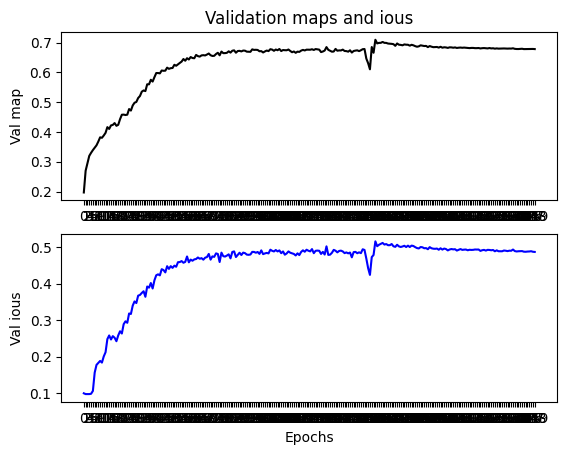

In [26]:
plt.subplot(2, 1, 1)
plt.ylabel('Val map')
plt.plot(np.arange(len(aps_lst)), aps_lst, 'k-')
plt.title('Validation maps and ious')
plt.xticks(np.arange(len(aps_lst), dtype=int))

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(ious_lst)), ious_lst, 'b-')
plt.ylabel('Val ious')
plt.xlabel('Epochs')
plt.xticks(np.arange(len(ious_lst), dtype=int))
plt.savefig(os.path.join(work_dir, 'val_plot.png'))
plt.close(fig)

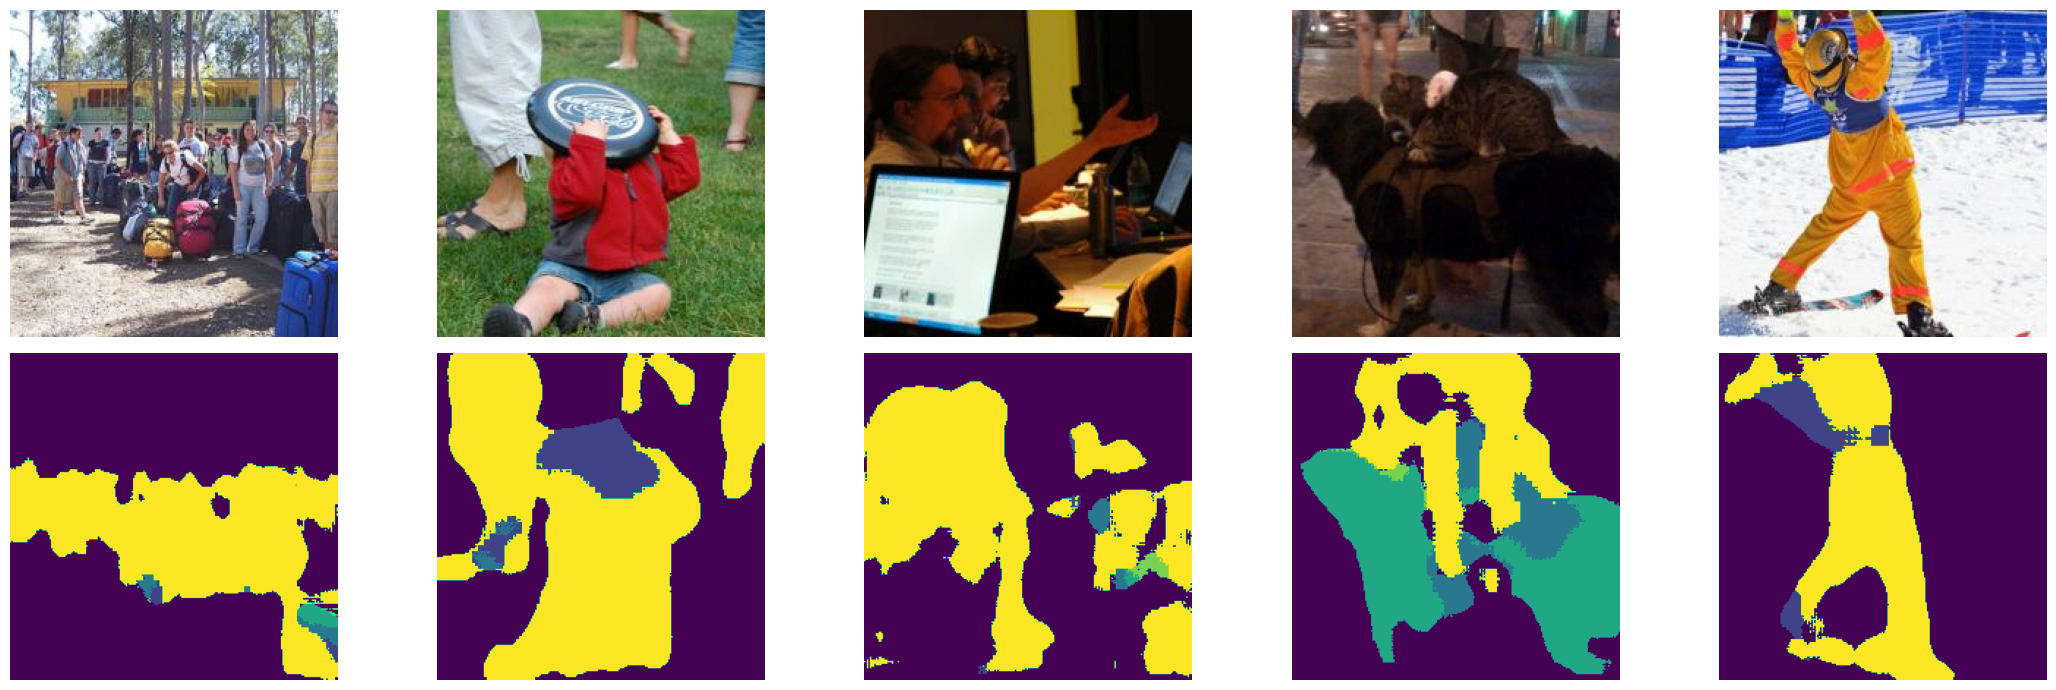

In [27]:
# visualization pred on validation set against GT
# Feel free to modify for your custom visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# vis input & pred on test set
save_path = os.path.join(work_dir, "vis")
os.makedirs(save_path, exist_ok=True)

vis_pred(mean, std, preds_lst[-1], val_dataset, os.path.join(save_path, "vis_valset.png"))

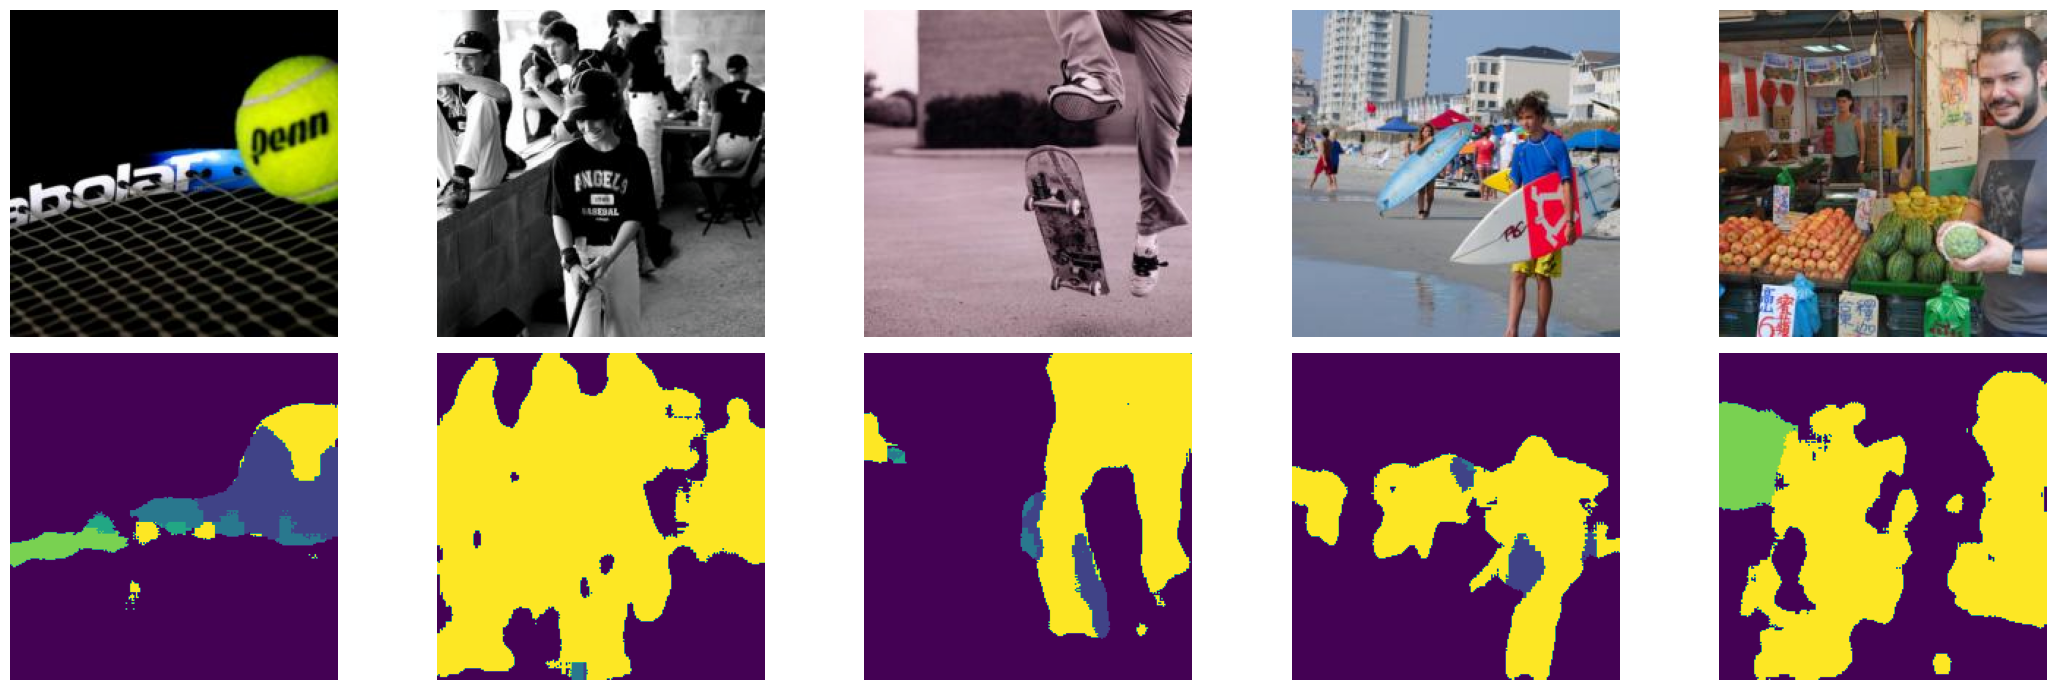

In [28]:
########################################################################
# No need to modify below
# Generate predictions on test split

test_dataset = SegmentationDataset(split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
preds = predict(model, test_dataloader, device)
vis_pred(mean, std, preds, test_dataset, os.path.join(save_path, "vis_testset.png"))

In [29]:
# save prediction, please upload to Gradescope
np.save('Q2_sseg_predictions', (preds*255).astype(np.uint8))

In [32]:
encoder = ResNetEncoder(models.resnet18(weights=models.ResNet18_Weights.DEFAULT))

In [33]:
model = SimpleSegNet(n_class=len(train_dataset.classes), encoder=encoder).to(device)

In [34]:
pred = model(next(iter(train_dataloader))[0].to(device))
target = next(iter(train_dataloader))[1].to(device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [35]:
criterion = Criterion().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30
decay_epochs = 20

In [36]:
criterion(pred, target.squeeze(-1))

tensor(1.9061, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [37]:
aps_lst, ious_lst, preds_lst = train_val(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, decay_epochs, device)

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 0, lr: 0.0001, performance on validation set
          background: AP: 0.88, IoU: 0.64
              sports: AP: 0.14, IoU: 0.00
           accessory: AP: 0.23, IoU: 0.00
              animal: AP: 0.73, IoU: 0.53
             vehicle: AP: 0.72, IoU: 0.47
              person: AP: 0.70, IoU: 0.49
                mean: AP: 0.57, IoU: 0.35


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 1, lr: 0.0001, performance on validation set
          background: AP: 0.89, IoU: 0.68
              sports: AP: 0.31, IoU: 0.00
           accessory: AP: 0.40, IoU: 0.13
              animal: AP: 0.81, IoU: 0.48
             vehicle: AP: 0.69, IoU: 0.35
              person: AP: 0.77, IoU: 0.50
                mean: AP: 0.65, IoU: 0.36


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 2, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.72
              sports: AP: 0.46, IoU: 0.27
           accessory: AP: 0.51, IoU: 0.29
              animal: AP: 0.84, IoU: 0.57
             vehicle: AP: 0.78, IoU: 0.55
              person: AP: 0.78, IoU: 0.53
                mean: AP: 0.71, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 3, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.72
              sports: AP: 0.48, IoU: 0.30
           accessory: AP: 0.51, IoU: 0.32
              animal: AP: 0.87, IoU: 0.64
             vehicle: AP: 0.77, IoU: 0.54
              person: AP: 0.80, IoU: 0.57
                mean: AP: 0.72, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 4, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.50, IoU: 0.29
           accessory: AP: 0.51, IoU: 0.25
              animal: AP: 0.88, IoU: 0.61
             vehicle: AP: 0.77, IoU: 0.50
              person: AP: 0.79, IoU: 0.56
                mean: AP: 0.73, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 5, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.49, IoU: 0.28
           accessory: AP: 0.55, IoU: 0.31
              animal: AP: 0.88, IoU: 0.61
             vehicle: AP: 0.77, IoU: 0.48
              person: AP: 0.80, IoU: 0.57
                mean: AP: 0.74, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 6, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.73
              sports: AP: 0.51, IoU: 0.31
           accessory: AP: 0.51, IoU: 0.32
              animal: AP: 0.90, IoU: 0.65
             vehicle: AP: 0.79, IoU: 0.56
              person: AP: 0.81, IoU: 0.58
                mean: AP: 0.74, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 7, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.50, IoU: 0.26
           accessory: AP: 0.53, IoU: 0.31
              animal: AP: 0.89, IoU: 0.66
             vehicle: AP: 0.77, IoU: 0.52
              person: AP: 0.80, IoU: 0.56
                mean: AP: 0.73, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 8, lr: 0.0001, performance on validation set
          background: AP: 0.91, IoU: 0.73
              sports: AP: 0.52, IoU: 0.30
           accessory: AP: 0.53, IoU: 0.30
              animal: AP: 0.90, IoU: 0.68
             vehicle: AP: 0.74, IoU: 0.41
              person: AP: 0.81, IoU: 0.57
                mean: AP: 0.73, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 9, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.51, IoU: 0.23
           accessory: AP: 0.53, IoU: 0.32
              animal: AP: 0.89, IoU: 0.66
             vehicle: AP: 0.77, IoU: 0.53
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.74, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 10, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.51, IoU: 0.25
           accessory: AP: 0.54, IoU: 0.33
              animal: AP: 0.90, IoU: 0.65
             vehicle: AP: 0.78, IoU: 0.54
              person: AP: 0.81, IoU: 0.58
                mean: AP: 0.74, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 11, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.54, IoU: 0.32
           accessory: AP: 0.54, IoU: 0.32
              animal: AP: 0.90, IoU: 0.67
             vehicle: AP: 0.78, IoU: 0.56
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.75, IoU: 0.53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 12, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.53, IoU: 0.29
           accessory: AP: 0.53, IoU: 0.32
              animal: AP: 0.90, IoU: 0.68
             vehicle: AP: 0.77, IoU: 0.55
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.75, IoU: 0.53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 13, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.54, IoU: 0.27
           accessory: AP: 0.51, IoU: 0.30
              animal: AP: 0.90, IoU: 0.62
             vehicle: AP: 0.77, IoU: 0.52
              person: AP: 0.80, IoU: 0.56
                mean: AP: 0.74, IoU: 0.50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 14, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.55, IoU: 0.30
           accessory: AP: 0.53, IoU: 0.30
              animal: AP: 0.90, IoU: 0.66
             vehicle: AP: 0.76, IoU: 0.47
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.75, IoU: 0.51


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 15, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.54, IoU: 0.30
           accessory: AP: 0.54, IoU: 0.33
              animal: AP: 0.90, IoU: 0.67
             vehicle: AP: 0.77, IoU: 0.55
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.75, IoU: 0.53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 16, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.75
              sports: AP: 0.52, IoU: 0.31
           accessory: AP: 0.54, IoU: 0.33
              animal: AP: 0.90, IoU: 0.65
             vehicle: AP: 0.76, IoU: 0.53
              person: AP: 0.81, IoU: 0.57
                mean: AP: 0.74, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 17, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.54, IoU: 0.27
           accessory: AP: 0.55, IoU: 0.33
              animal: AP: 0.90, IoU: 0.68
             vehicle: AP: 0.76, IoU: 0.55
              person: AP: 0.83, IoU: 0.57
                mean: AP: 0.75, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 18, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.53, IoU: 0.31
           accessory: AP: 0.56, IoU: 0.33
              animal: AP: 0.91, IoU: 0.68
             vehicle: AP: 0.76, IoU: 0.52
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.75, IoU: 0.53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 19, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.55, IoU: 0.28
           accessory: AP: 0.56, IoU: 0.33
              animal: AP: 0.90, IoU: 0.65
             vehicle: AP: 0.77, IoU: 0.55
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.75, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 20, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.75
              sports: AP: 0.56, IoU: 0.29
           accessory: AP: 0.56, IoU: 0.34
              animal: AP: 0.91, IoU: 0.67
             vehicle: AP: 0.76, IoU: 0.51
              person: AP: 0.82, IoU: 0.58
                mean: AP: 0.76, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 21, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.75
              sports: AP: 0.56, IoU: 0.31
           accessory: AP: 0.53, IoU: 0.29
              animal: AP: 0.91, IoU: 0.67
             vehicle: AP: 0.76, IoU: 0.56
              person: AP: 0.83, IoU: 0.59
                mean: AP: 0.75, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 22, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.53, IoU: 0.25
           accessory: AP: 0.53, IoU: 0.30
              animal: AP: 0.90, IoU: 0.63
             vehicle: AP: 0.74, IoU: 0.47
              person: AP: 0.82, IoU: 0.56
                mean: AP: 0.74, IoU: 0.49


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 23, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.55, IoU: 0.26
           accessory: AP: 0.55, IoU: 0.34
              animal: AP: 0.91, IoU: 0.69
             vehicle: AP: 0.76, IoU: 0.55
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.75, IoU: 0.53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 24, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.75
              sports: AP: 0.54, IoU: 0.33
           accessory: AP: 0.54, IoU: 0.33
              animal: AP: 0.90, IoU: 0.66
             vehicle: AP: 0.76, IoU: 0.53
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.75, IoU: 0.53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 25, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.54, IoU: 0.27
           accessory: AP: 0.55, IoU: 0.34
              animal: AP: 0.91, IoU: 0.67
             vehicle: AP: 0.75, IoU: 0.51
              person: AP: 0.82, IoU: 0.57
                mean: AP: 0.75, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 26, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.75
              sports: AP: 0.55, IoU: 0.28
           accessory: AP: 0.54, IoU: 0.33
              animal: AP: 0.91, IoU: 0.68
             vehicle: AP: 0.74, IoU: 0.52
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.75, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 27, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.54, IoU: 0.29
           accessory: AP: 0.54, IoU: 0.30
              animal: AP: 0.91, IoU: 0.69
             vehicle: AP: 0.75, IoU: 0.53
              person: AP: 0.82, IoU: 0.59
                mean: AP: 0.75, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 28, lr: 0.0001, performance on validation set
          background: AP: 0.93, IoU: 0.75
              sports: AP: 0.55, IoU: 0.29
           accessory: AP: 0.56, IoU: 0.34
              animal: AP: 0.91, IoU: 0.67
             vehicle: AP: 0.74, IoU: 0.53
              person: AP: 0.81, IoU: 0.54
                mean: AP: 0.75, IoU: 0.52


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 29, lr: 0.0001, performance on validation set
          background: AP: 0.92, IoU: 0.74
              sports: AP: 0.53, IoU: 0.26
           accessory: AP: 0.55, IoU: 0.33
              animal: AP: 0.91, IoU: 0.66
             vehicle: AP: 0.74, IoU: 0.49
              person: AP: 0.83, IoU: 0.58
                mean: AP: 0.75, IoU: 0.51


In [ ]:
plt.subplot(2, 1, 1)
plt.ylabel('Val map')
plt.plot(np.arange(len(aps_lst)), aps_lst, 'k-')
plt.title('Validation maps and ious')
plt.xticks(np.arange(len(aps_lst), dtype=int))

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(ious_lst)), ious_lst, 'b-')
plt.ylabel('Val ious')
plt.xlabel('Epochs')
plt.xticks(np.arange(len(ious_lst), dtype=int))
plt.savefig(os.path.join(work_dir, 'val_plot.png'))
plt.close(fig)

In [ ]:
save_path = os.path.join(work_dir, "vis")
os.makedirs(save_path, exist_ok=True)

vis_pred(mean, std, preds_lst[-1], val_dataset, os.path.join(save_path, "vis_ori_valset.png"))

In [ ]:
test_dataset = SegmentationDataset(split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
preds = predict(model, test_dataloader, device)
vis_pred(mean, std, preds, test_dataset, os.path.join(save_path, "vis_ori_testset.png"))

In [ ]:
np.save('Q2_ori_sseg_predictions', (preds*255).astype(np.uint8))